**OBJECTIVE:** Explore the dataset [estadao/basometro](https://github.com/estadao/basometro)

In [231]:
import numpy as np
import pandas as pd
import matplotlib

%config InlineBackend.figure_formats = ['svg']
from plotnine import *


## COLOR PALETTE

# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Data Input

In [232]:
df = pd.read_csv("../data/basometro.csv")
df.head()

,parlamentar,ideCadastro,UF,voto,partido,descricaoPartido,orientacaoGoverno,data,hora,governo,idVotacao,tipoProposicao,numeroProposicao,anoProposicao
0,Alceste Almeida,73979,RR,Não,MDB,Movimento Democrático Brasileiro,Não,2003-08-12 00:00:00,11:59,Lula 1,12-8-2003.11.59.810,MPV,121,2003
1,Nilson Mourão,74365,AC,Não,PT,Partido dos Trabalhadores,Não,2003-08-12 00:00:00,11:59,Lula 1,12-8-2003.11.59.810,MPV,121,2003
2,Dr. Benedito Dias,74343,AP,Não,Progressistas,Antigo Partido Progresista (PP),Não,2003-08-12 00:00:00,11:59,Lula 1,12-8-2003.11.59.810,MPV,121,2003
3,José Priante,74079,PA,Não,MDB,Movimento Democrático Brasileiro,Não,2003-08-12 00:00:00,11:59,Lula 1,12-8-2003.11.59.810,MPV,121,2003
4,Nicias Ribeiro,74080,PA,Sim,PSDB,Partido da Social Democracia Brasileira,Não,2003-08-12 00:00:00,11:59,Lula 1,12-8-2003.11.59.810,MPV,121,2003


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286999 entries, 0 to 1286998
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   parlamentar        1286999 non-null  category      
 1   ideCadastro        1286999 non-null  category      
 2   UF                 1286999 non-null  category      
 3   voto               1286999 non-null  category      
 4   partido            1286999 non-null  category      
 5   descricaoPartido   1285508 non-null  object        
 6   orientacaoGoverno  1232592 non-null  category      
 7   data               1286999 non-null  datetime64[ns]
 8   governo            1286999 non-null  object        
 9   idVotacao          1286999 non-null  object        
 10  tipoProposicao     1286999 non-null  category      
 11  numeroProposicao   1286999 non-null  int64         
 12  anoProposicao      1286999 non-null  int64         
dtypes: category(7), datetime64[

## Date format inconsistency

Just to note: The format of the data in the `data` column changed over time and, as a result, it now has two different string formats:

In [234]:
df["data"].apply(len).value_counts()

19    1285508
10       1491
Name: data, dtype: int64

In [235]:
df.assign(len_field_data=df["data"].apply(len)).groupby(["len_field_data"]).first()[["data"]]

,data
len_field_data,
10,2017-08-02
19,2003-08-12 00:00:00


## Preprocessing

**Concat data+hora and convert to datetime**

In [236]:
df["data"] = pd.to_datetime(df.apply(lambda x: x["data"][0:10] + " " + x["hora"], axis=1))
df.drop(columns=["hora"], inplace=True)

**Parse categorical variables as such:**

In [246]:
categorical_cols = ["UF", "governo", "orientacaoGoverno", "parlamentar", "partido", "tipoProposicao", "voto", "ideCadastro"]

for col in categorical_cols:
    df[col] = pd.Categorical(df[col])
    
df["governo"] = pd.Categorical(np.where(df["data"].dt.year == 2022, "Bolsonaro 1", df["governo"]))
df["governo"] = df["governo"].cat.reorder_categories(["Lula 1", "Lula 2", "Dilma 1", "Dilma 2", "Temer 1", "Bolsonaro 1"])

df["orientacaoGoverno"] = df["orientacaoGoverno"].cat.reorder_categories(['Sim', 'Não', 'Liberado', 'Obstrução', 'Abstenção'])

**Some data are more efficiently encoded as integers:**

In [247]:
integer_cols = ["anoProposicao", "numeroProposicao"]

for col in integer_cols:
    df[col] = df[col].astype(int, errors='ignore')
    
df = df.assign(anoVotacao = lambda x: x["data"].dt.year)

The resulting dataset looks like this:

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286999 entries, 0 to 1286998
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   parlamentar        1286999 non-null  category      
 1   ideCadastro        1286999 non-null  category      
 2   UF                 1286999 non-null  category      
 3   voto               1286999 non-null  category      
 4   partido            1286999 non-null  category      
 5   descricaoPartido   1285508 non-null  object        
 6   orientacaoGoverno  1232592 non-null  category      
 7   data               1286999 non-null  datetime64[ns]
 8   governo            1286999 non-null  category      
 9   idVotacao          1286999 non-null  object        
 10  tipoProposicao     1286999 non-null  category      
 11  numeroProposicao   1286999 non-null  int64         
 12  anoProposicao      1286999 non-null  int64         
 13  anoVotacao         1286999 

In [249]:
df.head()

,parlamentar,ideCadastro,UF,voto,partido,descricaoPartido,orientacaoGoverno,data,governo,idVotacao,tipoProposicao,numeroProposicao,anoProposicao,anoVotacao
0,Alceste Almeida,73979,RR,Não,MDB,Movimento Democrático Brasileiro,Não,2003-08-12 11:59:00,Lula 1,12-8-2003.11.59.810,MPV,121,2003,2003
1,Nilson Mourão,74365,AC,Não,PT,Partido dos Trabalhadores,Não,2003-08-12 11:59:00,Lula 1,12-8-2003.11.59.810,MPV,121,2003,2003
2,Dr. Benedito Dias,74343,AP,Não,Progressistas,Antigo Partido Progresista (PP),Não,2003-08-12 11:59:00,Lula 1,12-8-2003.11.59.810,MPV,121,2003,2003
3,José Priante,74079,PA,Não,MDB,Movimento Democrático Brasileiro,Não,2003-08-12 11:59:00,Lula 1,12-8-2003.11.59.810,MPV,121,2003,2003
4,Nicias Ribeiro,74080,PA,Sim,PSDB,Partido da Social Democracia Brasileira,Não,2003-08-12 11:59:00,Lula 1,12-8-2003.11.59.810,MPV,121,2003,2003


# Data Summary

**What is in the data?**

## Date Range

In [250]:
print(f"Date range: {df['data'].dt.year.min()} -- {df['data'].dt.year.max()}")

Date range: 2003 -- 2022


In [251]:
print(f"Date range: {df['data'].max() - df['data'].min()}")

Date range: 7001 days 03:29:00


## How many propositions were voted per year?

In [253]:
df.groupby(["governo", "anoVotacao"])["numeroProposicao"].nunique().to_frame().query("numeroProposicao > 0")

numeroProposicao
governo     anoVotacao                  
Lula 1      2003                      54
            2004                      54
            2005                      33
            2006                      38
Lula 2      2007                      64
            2008                      57
            2009                      55
            2010                      39
Dilma 1     2011                      38
            2012                      45
            2013                      75
            2014                      49
Dilma 2     2015                      91
            2016                      24
Temer 1     2016                      50
            2017                      92
            2018                      56
Bolsonaro 1 2019                      81
            2020                       1
            2021                     187
            2022                      54

## How did governments recommend to vote in each proposition?

In [254]:
css_properties = {'width': '80px', 'height': '30px', 'font-size':'14px', 'font-weight': 'bold', 'text-align': 'center'}


df.groupby(["governo", "orientacaoGoverno"])["numeroProposicao"].nunique().to_frame()\
  .query("numeroProposicao > 0").reset_index()\
  .pivot(index="governo", columns="orientacaoGoverno", values="numeroProposicao").fillna(0)\
  .style.format(precision=0).set_properties(**css_properties)\
  .applymap_index(lambda x: 'font-size: 15px;', axis=0)\
  .applymap_index(lambda x: 'font-size: 16px; text-align: center;', axis=1)\
  .background_gradient(cmap='Purples', vmin=10, vmax=100)

orientacaoGoverno,Sim,Não,Liberado,Obstrução,Abstenção
governo,,,,,
Lula 1,96,91,43,3,1
Lula 2,138,91,68,8,0
Dilma 1,92,78,78,6,0
Dilma 2,74,40,34,2,0
Temer 1,125,75,62,4,0
Bolsonaro 1,218,143,61,1,0


## Column `partido`

How many are there?

In [255]:
df["partido"].nunique()

40

List name of all political parties represented in the dataset:

In [256]:
df["partido"].unique().categories

Index(['Avante', 'Cidadania', 'DC', 'DEM', 'MDB', 'NOVO', 'Novo', 'PAN',
       'PCdoB', 'PDT', 'PHS', 'PL', 'PMB', 'PMN', 'PPL', 'PRB', 'PRONA',
       'PROS', 'PRP', 'PRTB', 'PSB', 'PSC', 'PSD', 'PSDB', 'PSL', 'PSOL',
       'PST', 'PT', 'PTB', 'PTC', 'PV', 'Patriota', 'Podemos', 'Progressistas',
       'REDE', 'Rede', 'Republican', 'Sem Partido', 'Solidariedade', 'União'],
      dtype='object')

## Column `tipoProposicao`

Maybe the type of proposition is important?

In [271]:
df["tipoProposicao"].value_counts()

MPV    456462
PL     296126
PEC    246983
PLP    131213
REQ    101220
PDC     13827
PLN     10984
PRC     10878
PDL      5458
MSC      5350
REC      4663
REP      2071
DCR      1491
PLV       273
Name: tipoProposicao, dtype: int64

# Exploratory Data Analysis

How do political parties vote over time?

## How many propositions are there per year?

In [272]:
plot_df = df.assign(anoVotacao = lambda x: x["data"].dt.year)\
    .groupby(["governo", "anoVotacao"])\
    .apply(lambda x: pd.Series({"count": x["numeroProposicao"].nunique()})).reset_index().dropna()

/home/jonathan/Workspace/eda-dados-basometro/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_col : Removed 1 rows containing missing values.


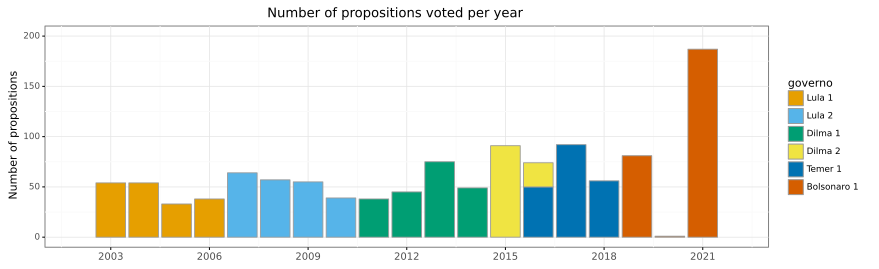

<ggplot: (8734712380450)>

In [276]:
g = (ggplot(plot_df, aes(x="anoVotacao", y="count", fill="governo")) + 
     geom_col(color=cbPalette[0]) + 
     theme_bw() +
     scale_y_continuous(name="Number of propositions", limits=(0, 200)) +
     scale_x_continuous(name="", limits=(2002, 2022), breaks=range(2003, 2022, 3)) + 
     scale_fill_manual(values=cbPalette[1:]) + 
     theme(figure_size=(13, 4),
           axis_text_x=element_text(size=10)) +
     ggtitle("Number of propositions voted per year")
    )
g

## What was the government official position on each proposition?

In [277]:
plot_df = df.assign(anoVotacao = lambda x: x["data"].dt.strftime("%Y"))\
    .groupby(["governo", "anoVotacao", "numeroProposicao"]).tail(n=1)\
    .groupby(["governo", "anoVotacao", "orientacaoGoverno"])\
    .apply(lambda x: pd.Series({"count": x["numeroProposicao"].nunique()})).reset_index().dropna()
    
# plot_df

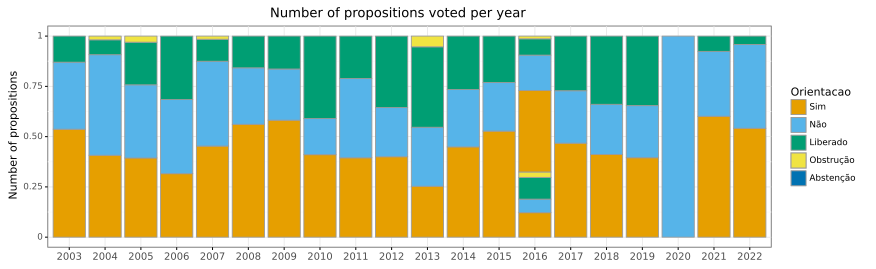

<ggplot: (8734711955231)>

In [299]:
# Count number of propositions voted pre-impeachemnt
count_dilma_2016 = plot_df[(plot_df["anoVotacao"] == "2016") & (plot_df["governo"] == "Dilma 2")]["count"].sum()
count_dilma_2016 = count_dilma_2016/plot_df[(plot_df["anoVotacao"] == "2016")]["count"].sum()

g = (ggplot(plot_df, aes(x="anoVotacao", y="count", fill="orientacaoGoverno", group="anoVotacao")) + 
     geom_bar(color=cbPalette[0], position="fill", stat="identity") + 
     theme_bw() +
     scale_y_continuous(name="Number of propositions") +
     scale_x_discrete(name="") + 
     scale_fill_manual(name="Orientacao ", values=cbPalette[1:]) + 
     theme(figure_size=(13, 4),
           axis_text_x=element_text(size=10)) +
     ggtitle("Number of propositions voted per year")
     
     )
g

# Convert to HiPerMovelets JSON 

Convert to format understood by HiPerMovelets

>
> Tarlis Tortelli Portela, Jonata Tyska Carvalho & Vania Bogorny (2022)
> _HiPerMovelets: high-performance movelet extraction for trajectory classification_, International Journal of Geographical Information Science, 36:5, 1012-1036, DOI: [10.1080/13658816.2021.2018593](https://doi.org/10.1080/13658816.2021.2018593)

In [260]:
df.assign(year=df.data.dt.year).groupby(["year"]).apply(lambda x: pd.Series({"num_null": x["governo"].isnull().sum()}))

,num_null
year,
2003,0
2004,0
2005,0
2006,0
2007,0
2008,0
2009,0
2010,0
2011,0


In [261]:
# Time offset to match JSON naming standard
df["tid"] = (df.data - df.data.min()).dt.days + 1

In [300]:
df.sort_values(["tid", "idVotacao"])[["tid", "UF", "voto", "orientacaoGoverno", "anoProposicao", "anoVotacao", "tipoProposicao", "partido", "governo", "parlamentar", "data", "idVotacao"]]

,tid,UF,voto,orientacaoGoverno,anoProposicao,anoVotacao,tipoProposicao,partido,governo,parlamentar,data,idVotacao
17304,1,AC,Sim,Sim,2002,2003,MSC,PT,Lula 1,Nilson Mourão,2003-02-25 18:54:00,25-2-2003.18.54.736
17305,1,CE,Sim,Sim,2002,2003,MSC,MDB,Lula 1,Aníbal Gomes,2003-02-25 18:54:00,25-2-2003.18.54.736
17306,1,PR,Sim,Sim,2002,2003,MSC,DEM,Lula 1,Abelardo Lupion,2003-02-25 18:54:00,25-2-2003.18.54.736
17307,1,AP,Sim,Sim,2002,2003,MSC,Progressistas,Lula 1,Dr. Benedito Dias,2003-02-25 18:54:00,25-2-2003.18.54.736
17308,1,RR,Sim,Sim,2002,2003,MSC,DEM,Lula 1,Luciano Castro,2003-02-25 18:54:00,25-2-2003.18.54.736
...,...,...,...,...,...,...,...,...,...,...,...,...
1273610,7002,RJ,Não,Não,2020,2022,PL,PSD,Bolsonaro 1,Jones Moura,2022-04-27 22:23:00,27-4-2022.22.23.17238
1273611,7002,AP,Não,Não,2020,2022,PL,PL,Bolsonaro 1,Jorielson,2022-04-27 22:23:00,27-4-2022.22.23.17238
1273612,7002,CE,Não,Não,2020,2022,PL,União,Bolsonaro 1,Nelho Bezerra,2022-04-27 22:23:00,27-4-2022.22.23.17238
1273613,7002,SP,Não,Não,2020,2022,PL,PSD,Bolsonaro 1,Eleuses Paiva,2022-04-27 22:23:00,27-4-2022.22.23.17238
